# Guia 6

## Ejercicio 1

Implemente las estructuras de datos y algorítmos básicos para la solución de un problema mediante algorítmos genéticos. Pruebe estas rutinas y compare los resultados con un método de gradiente descendiente para buscar el mínimo global de las siguientes funciones:

- $f(x) = -xsin(\sqrt{|x|}$ con $x \in [-512...512]$
- $f(x,y) = (x^2+y^2)^{0.25} [sin^2(50(x^2+y^2)^{0.1})+1]$, con $x,y \in [-100...100]$, como se puede ver en la siguiente figura

![](https://raw.githubusercontent.com/Lucasa98/Inteligencia-Computacional-2025/refs/heads/main/rsc/g6e1.png)

In [1]:
from sklearn.neural_network import MLPClassifier
import os
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    x = np.atleast_1d(x)
    f = -x*np.sin(np.sqrt(np.abs(x)))
    return f if f.shape[0] > 1 else f[0]

def df1(x):
    x = np.atleast_1d(x)
    df = -np.sin(np.sqrt(np.abs(x))) - ((np.power(x,2)*np.cos(np.sqrt(np.abs(x)))) / (2*np.abs(x)*np.sqrt(np.abs(x))))
    return df if df.shape[0] > 1 else df[0]

rng = np.random.default_rng()

# Metodo del gradiente
grad_ini = rng.random(1,dtype=float)[0]*1024-512
grad = grad_ini
c_it = 0
while(np.abs(df1(grad)) > 0.001):
    c_it += 1
    grad = grad - df1(grad)
print(c_it)

33


In [2]:
# ===== Algoritmo evolutivo =====
# funcion de decodificacion
def b2f(x: np.ndarray[np.uint8]) -> np.ndarray[float]|float:
    x = np.atleast_2d(x)
    # una poblacion
    N, B = x.shape  # N individuos, B bits por individuo
    potencias = 1 << np.arange(B-1, -1, -1, dtype=np.uint64)    # 2^(B-1), 2^(B-2), ..., 1
    ints = (x * potencias).sum(axis=1)
    norm = ints / (2**B - 1)
    floats = - 512 + norm * 1024
    return floats if x.shape[0] > 1 else floats[0]              # devolver uno o muchos dependen lo que llego

# funcion de binarizacion
def f2b(x: np.ndarray[float], B: int) -> np.ndarray[np.uint8]:
    x = np.atleast_1d(x)
    norm = x/1024 + 0.5
    ints = np.clip(np.round(norm * (2**B - 1)), 2**B - 1).astype(np.uint64)
    bits = ((ints[:, None] >> np.arange(B-1, -1, -1)) & 1).astype(np.uint8)
    return bits if len(x) > 1 else bits[0]

def fitness(x: np.ndarray[np.uint8]) -> np.ndarray[float]|float:
    # penalizamos los valores mas altos, tanto en la funcion como de su derivada (gradiente)
    floats = b2f(x)
    return -f1(floats) - df1(floats)

N = 200         # numero de individuos
B = 8           # bits por individuo
M = 20          # progenitores por generacion
m = 0.01        # probabilidad de mutacion
ventana = N//M  # tamanño de la ventana al seleccionar progenitores

# 1) inicializar la poblacion al azar
poblacion = rng.integers(0,2,(N,B),dtype=np.uint8)

for _ in range(20):
    # 2) calcular fitness
    fit = fitness(poblacion)

    # 3) elegir progenitores (metodo de la ventana)
    sorted = np.argsort(fit)    # indices que ordenan de menor a mayor
    progenitores = np.empty((M,B),dtype=np.uint8)
    v = ventana
    for i in range(M):
        progenitores[i] = poblacion[sorted[-rng.integers(0,v,1)]]
        v += ventana

    # 4) cruzar progenitores (cruza simple)
    poblacion[:M] = progenitores
    for i in range(M,N):
        p1, p2 = rng.integers(0,M,2)    # tomar progenitores al azar
        c = rng.integers(0,B,2).sort()  # punto de cruza
        poblacion[i,:c] = progenitores[p1][:c]
        poblacion[i,c:] = progenitores[p2][c:]
        # mutar
        if rng.random() < m:
            b = rng.integers(0,B)
            poblacion[i][b] = 0 if poblacion[i][b] == 1 else 1


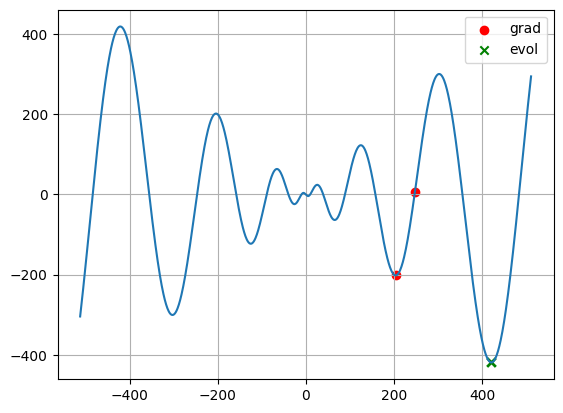

In [3]:
fit = fitness(poblacion)
sorted = np.argsort(fit)
ganadores = poblacion[-6:-1]
resultados = b2f(ganadores)
# Grafica de la funcion
x = np.arange(-512, 512, 1)
y = f1(x)

fig, ax = plt.subplots(1)
ax.grid()
ax.plot(x,y)
ax.scatter([grad_ini,grad],[f1(grad_ini),f1(grad)], c='r', label='grad')
ax.scatter(resultados, f1(resultados), c='g', label='evol', marker='x')
_ = ax.legend()